# 프로세스 준비

In [ ]:
# !pip install ee
# !pip install geemap
# !pip install ipympl

In [1]:
import ee, geemap, os, shutil
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import ipyleaflet
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import numpy as np
import cufflinks as cf
cf.go_offline(connected=True)

In [2]:
geemap.ee_initialize()

In [3]:
def addNDVI(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands([ndvi])

In [4]:
def maskS2clouds(image):
    qa = image.select('QA60')
    
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0) and qa.bitwiseAnd(cirrusBitMask).eq(0))
        
    return image.updateMask(mask)

In [5]:
def clipPoint(image):
    return image.clip(ee.Geometry.Point(point).buffer(250).bounds())\
                .reduceRegions(
                     collection = points,
                     reducer = ee.Reducer.mean(),
                     scale = 10)

---
# 위성 이미지 출력

In [6]:
table = geemap.shp_to_ee('shp file here')
df = geemap.ee_to_df(table)

In [7]:
coords = df[['Location', 'Lon', 'Lat']].drop_duplicates()

coords_dict = {'GBK_coord' : [coords.iloc[0, 1], coords.iloc[0, 2]],
               'AMD_coord' : [coords.iloc[1, 1], coords.iloc[1, 2]],
               'WD_coord'  : [coords.iloc[2, 1], coords.iloc[2, 2]],
               'HC_coord'  : [coords.iloc[3, 1], coords.iloc[3, 2]],
               'PYC_coord' : [coords.iloc[4, 1], coords.iloc[4, 2]],
               'SC_coord'  : [coords.iloc[5, 1], coords.iloc[5, 2]],
               'JJ_coord'  : [coords.iloc[6, 1], coords.iloc[6, 2]],
               'GCK_coord' : [coords.iloc[7, 1], coords.iloc[7, 2]],
             'HAWS1_coord' : [coords.iloc[8, 1], coords.iloc[8, 2]], }

- location 변수에 Location 코드 입력하여 사용

In [8]:
loc_list = list(coords['Location'].values)
loc_list

['GBK', 'AMD', 'WD', 'HC', 'PYC', 'SC', 'JJ', 'GCK', 'HAWS1']

In [9]:
location = 'GCK'

point = coords_dict[f'{location}_coord']

start_date = '2022-01-01'
end_date = '2022-12-01'

images = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
       .select(['B2', 'B3', 'B4', 'B8', 'QA60'])
       .filterDate(start_date, end_date)
       .filterBounds(ee.Geometry.Point(point))
       .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
       .map(addNDVI)
       .map(maskS2clouds))

vis = {'bands': ['B4', 'B3', 'B2'],
       'min': 0,
       'max': 3000,
       'gamma':1.4  }

In [ ]:
size = images.size()
print(f'{location} data size : {size.getInfo()}')

images_list = images.toList(size)
print(f'{location} data_list size : {images_list.length().getInfo()}')

- TODO

    - 버튼 만들어서 날짜별 조회하게 만들기

In [11]:
Map = geemap.Map()
Map.setCenter(point[0], point[1], 15)
Map.addLayer(ee.Image(images_list.get(0)).clip(ee.Geometry.Point(point).buffer(500).bounds()), vis, 'Sentinel-2')
Map.addLayer(ee.Image().paint(ee.Geometry.Point(point).buffer(250).bounds(), 0, 1), {'palette': 'FF0000'}, 'Box Outline')
Map.addLayer(ee.Image().paint(ee.Geometry.Point(point).buffer(30), 0, 1), {'palette': 'FFFF00'}, 'Center point')
Map

Map(center=[37.7484, 127.163], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

---
# 데이터 생성 및 전처리

## 위성사진 png 저장

In [13]:
''' 일자 및 폴더 지정 '''
start_date = '2022-01-01'
end_date = '2022-12-01'
img_save_dir = f'{start_date}-{end_date}_Images'

In [ ]:
''' 폴더 생성 '''
if os.path.exists(img_save_dir):
    shutil.rmtree(img_save_dir)
os.makedirs(img_save_dir)

''' 전체 관측일자 Image 저장 '''
for location in loc_list:
    point = coords_dict[f'{location}_coord']

    images = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
           .select(['B2', 'B3', 'B4', 'B8', 'QA60'])
           .filterDate(start_date, end_date)
           .filterBounds(ee.Geometry.Point(point))
           .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
           .map(addNDVI)
           .map(maskS2clouds))
    
    vis = {'bands': ['B4', 'B3', 'B2'],
       'min': 0,
       'max': 3000,
       'gamma':1.4  }
    
    size = images.size()
    images_list = images.toList(size)
    
    for num in range(size.getInfo()):
        targetImage = ee.Image(images_list.get(num)).clip(ee.Geometry.Point(point).buffer(500).bounds())
        datetime = ee.Date(ee.Image(images_list.get(num)).get('system:time_start')).format().getInfo()
        filename = f"{img_save_dir}\\{location}_Images\\{location}_{datetime[:10]}.png"
        
        for i in range(1, 5):
            if not os.path.exists(filename):
                filename = filename
            elif os.path.exists(filename):
                filename = f"{img_save_dir}\\{location}_Images\\{location}_{datetime[:10]}({i}).png"
            
        geemap.get_image_thumbnail(targetImage, filename, vis, dimensions=1000)
        print(f"{filename} 생성 완료.")
    print(f"총 {size.getInfo()}개 Image 생성 완료.", "="*50, sep="\n")

## 시계열 테이블 전처리 및 저장

In [17]:
''' FeatureCollection 생성 '''
points = ee.FeatureCollection(table)

In [18]:
''' 일자 및 폴더 지정 '''
start_date = '2022-01-01'
end_date = '2022-12-01'
csv_save_dir = f'{start_date}-{end_date}_Time-Series'

In [ ]:
''' 폴더 생성 '''
if os.path.exists(csv_save_dir):
    shutil.rmtree(csv_save_dir)
os.makedirs(csv_save_dir)

''' 지점별로 시계열 csv파일 생성, 전처리, 이후 활용할 df 생성 반복 '''
for location in loc_list:
    point = coords_dict[f'{location}_coord']
    
    images = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
           .select(['B2', 'B3', 'B4', 'B8', 'QA60'])
           .filterDate(start_date, end_date)
           .filterBounds(ee.Geometry.Point(point))
           .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
           .map(addNDVI)
           .map(maskS2clouds))

    features = images.map(clipPoint).flatten()
    
    geemap.ee_to_csv(features, f'{csv_save_dir}\\temp.csv')
    feature_df = pd.read_csv(f'{csv_save_dir}\\temp.csv', encoding='utf-8')
    feature_df_cleaned = feature_df.reset_index().sort_values(by=['Location', 'index'])
    feature_df_cleaned = feature_df_cleaned[['system:index', 'Location', 'BUFF_DIST', 'B2', 'B3', 'B4', 'B8', 'NDVI']].dropna() 
    feature_df_cleaned.rename(columns={'B2':'Blue', 'B3':'Green', 'B4':'Red', 'B8':'NIR'}, inplace=True)
    feature_df_cleaned[['Blue', 'Green', 'Red', 'NIR']] *= 0.0001
    feature_df_cleaned.rename(columns={'system:index':'DATE'}, inplace=True)
    feature_df_cleaned['DATE'] = feature_df_cleaned['DATE'].apply(lambda x: f"{x[:4]}-{x[4:6]}-{x[6:8]}")

    feature_df_cleaned.to_csv(f'{csv_save_dir}\\S2_{location}-{start_date}-{end_date}_timeseries.csv', encoding='utf-8', index=False)
    globals()[f'{location}_df'] = feature_df_cleaned.copy()
    
os.remove(f'{csv_save_dir}\\temp.csv')

In [20]:
''' 통합 df 생성 '''
total_df = pd.concat([globals()[f'{location}_df'] for location in loc_list], axis=0)
total_df.to_csv(f'{csv_save_dir}\\S2_TOTAL-{start_date}-{end_date}_timeseries.csv', encoding='utf-8', index=False)

total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1056 entries, 0 to 863
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       1056 non-null   object 
 1   Location   1056 non-null   object 
 2   BUFF_DIST  1056 non-null   int64  
 3   Blue       1056 non-null   float64
 4   Green      1056 non-null   float64
 5   Red        1056 non-null   float64
 6   NIR        1056 non-null   float64
 7   NDVI       1056 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 74.2+ KB


---
# 데이터 시각화

- 데이터 로드

In [21]:
total_df = pd.read_csv(f'{csv_save_dir}\\S2_TOTAL-{start_date}-{end_date}_timeseries.csv', encoding='utf-8')

## 지역별 관측 개수 시각화

In [ ]:
# 그래프에 한글 출력 시 사용

font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

In [ ]:
counts = total_df['Location'].value_counts()/6

plt.figure(figsize=(8, 8))
plt.title('Observation number by Location')
bars = plt.bar(counts.index, counts, width=0.4)
plt.ylim(0, counts.max()*1.25) 

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, 
             height, f'{height:.1f}', ha='center', va='bottom', size = 11)
    
plt.show()

## 일별 테이블

In [23]:
location = widgets.Dropdown(options=loc_list)
date = widgets.Dropdown(options=total_df['DATE'][total_df['Location'] == location.value].drop_duplicates())

def change_loc(*args):
    date.options = total_df['DATE'][total_df['Location'] == location.value].drop_duplicates()

location.observe(change_loc, 'value')

@interact
def showByDate( Location = location,
                Date = date ):

    return total_df.loc[(total_df.Location == Location) & (total_df.DATE == Date)]

interactive(children=(Dropdown(description='Location', options=('GBK', 'AMD', 'WD', 'HC', 'PYC', 'SC', 'JJ', '…

## 일 / 밴드별 그래프

- 한 날짜에 관측 건수가 여러 건이 있어 중복되는 경우 평균으로 출력

In [24]:
location2 = widgets.Dropdown(options=loc_list)
date2 = widgets.Dropdown(options=total_df['DATE'][total_df['Location'] == location2.value].drop_duplicates())

def change_loc2(*args):
    date2.options = total_df['DATE'][total_df['Location'] == location2.value].drop_duplicates()

location2.observe(change_loc2, 'value')

@interact
def showByDateAndBand(Location = location2,
                      Date = date2,
                      Band = total_df.columns[-5:]
                     ):
    
    colorDict = {
        'Blue' : 'blue', 
       'Green' : 'green',
          'Red': 'red',
          'NIR': 'magenta',
         'NDVI': 'skyblue'
    }
    
    base = total_df[total_df['Location'] == Location].set_index(['BUFF_DIST'])
    data = base[base['DATE'] == Date].loc[:, Band].groupby('BUFF_DIST').mean()
    plt.figure(figsize=(9, 7))
    plt.plot(data, color=colorDict[Band])
    plt.xlabel('Buffer')
    plt.ylabel('Value', rotation=0, labelpad=14)
    plt.ylim(data.min() * 0.975, data.max() * 1.025)
    plt.title(f'{Location} | {Date} | {Band}')
    plt.grid(axis='y')
    plt.show()
    
    for buff, value in zip(data.index, data.values):
        print(f'{buff}M : {value:.7f}')

interactive(children=(Dropdown(description='Location', options=('GBK', 'AMD', 'WD', 'HC', 'PYC', 'SC', 'JJ', '…

## 전체 기간 지역별 평균 그래프

In [36]:
location3 = widgets.Dropdown(options=loc_list)

@interact
def showByLocationMean(Location = location3):
    
    location_df = total_df[total_df['Location'] == Location]
    groupMean = location_df.drop(axis=1, columns=['Location' ,'BUFF_DIST']).groupby('DATE').mean()
    
    colorDict = {
            'Blue' : 'blue', 
           'Green' : 'green',
              'Red': 'red',
              'NIR': 'magenta',
             'NDVI': 'skyblue'
        }

    groupMean.iplot(kind='line', subplots=True, subplot_titles=True,
                    title='Timeseries graph by Bands (Mean)', 
                    vertical_spacing=0.1, dimensions=(1150, 800),
                    colors=colorDict)

interactive(children=(Dropdown(description='Location', options=('GBK', 'AMD', 'WD', 'HC', 'PYC', 'SC', 'JJ', '…

---
# 미사용 코드

### 날짜별 조회

In [27]:
valid_date = target_df['DATE'].value_counts().index
valid_date

Index(['2022-01-07', '2022-01-17', '2022-02-06', '2022-02-11', '2022-03-03',
       '2022-03-08', '2022-04-02', '2022-04-07', '2022-04-17', '2022-04-27'],
      dtype='object')

- targetDate 변수에 조회 날짜의 인덱스 입력
-  targetBand 변수에 조회 밴드 입력

In [28]:
targetDate = valid_date[3]
targetBand = 'NIR'

In [29]:
target_line = target_df[target_df['DATE'] == targetDate].set_index(['BUFF_DIST']).loc[:, targetBand].T
target_line

BUFF_DIST
5     1361.126316
10    1388.348214
15    1423.828732
20    1437.492594
25    1440.307522
30    1430.193318
Name: NIR, dtype: float64

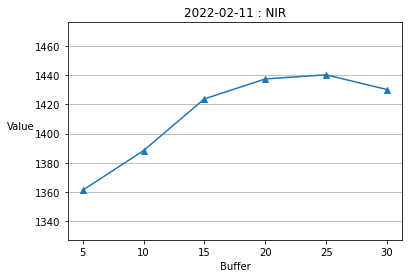

In [32]:
plt.plot(target_line, label = targetBand, marker='^')
plt.xlabel('Buffer')
plt.ylabel('Value', rotation=0, labelpad=14)
plt.ylim(target_line.min() * 0.975, target_line.max() * 1.025)
plt.title(f'{targetDate} : {targetBand}')
plt.grid(axis='y')
plt.show()

### 밴드별 전체 날짜 평균값 조회

In [33]:
target_mean = target_df.groupby(['BUFF_DIST']).mean()
target_mean.loc[:, 'NDVI'].T

BUFF_DIST
5     0.669248
10    0.672606
15    0.675778
20    0.676173
25    0.672285
30    0.665996
Name: NDVI, dtype: float64

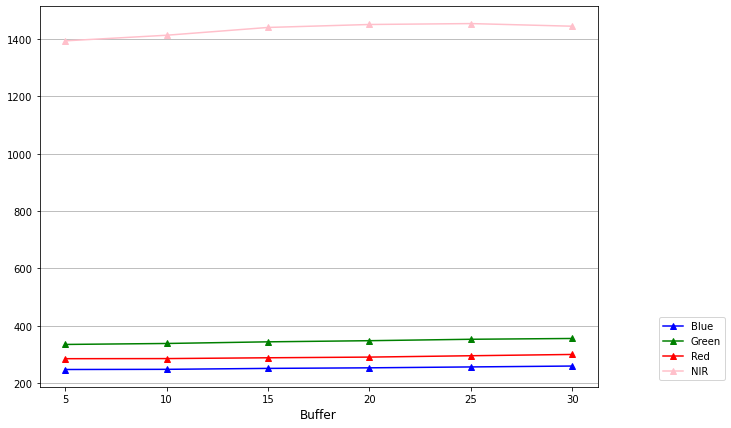

In [204]:
plt.rcParams['figure.figsize'] = (10, 7)

fig, ax1 = plt.subplots()
ax1.set_xlabel('Buffer', size=12)
blueLine = ax1.plot(target_mean.loc[:, 'Blue'].T, marker='^', color='b', label='Blue')
greenLine = ax1.plot(target_mean.loc[:, 'Green'].T, marker='^', color='g', label='Green')
redLine = ax1.plot(target_mean.loc[:, 'Red'].T, marker='^', color='r', label='Red')
NIRLine = ax1.plot(target_mean.loc[:, 'NIR'].T, marker='^', color='pink', label='NIR')


# ax2 = ax1.twinx()
# ax2.set_ylabel('Value', rotation=0, size=12, labelpad=25)
# NDVILine = ax2.plot(target_mean.loc[:, 'NDVI'].T, marker='^', color='purple', label='NDVI')

lines = blueLine + greenLine + redLine + NIRLine #+ NDVILine
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.1, 0.1))
plt.grid(axis='y')
plt.show()

- target 변수에 Location 코드 입력하여 진행

In [ ]:
print(target_list)

- TODO

Date, Band, Buffer 별로 조회할 수 있는 위젯 플롯 만들기

가능하면 Location도 추가

In [21]:
@interact_manual
def interactPlotting(Date=list(target_df['DATE'].drop_duplicates()),
                     Band=list(target_df.columns[-5:]),
                     Buffer=list(target_df['BUFF_DIST'].drop_duplicates())):
    target_df.iplot(kind= 'line', x=target_df)

interactive(children=(Dropdown(description='Date', options=('2022-01-07', '2022-01-17', '2022-02-06', '2022-02…

---
# 메모

- 전체 지점 데이터를 한 번에 만드는 것보다 각 지점 데이터를 구한 다음, 합치는 것이 더 나은 점??
    1. 어차피 각 지점으로 나눠야함
    2. 불필요한 데이터가 들어오는 걸 방지 가능
        - Geometry 변수 사용 시 범위 내 데이터가 있는 모든 날짜에서 각 Point를 추려내므로 데이터가 없는 날짜(row)가 너무 많음
        